<a href="https://colab.research.google.com/github/Miekevi/brainimaging_VU/blob/analysisdata/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2 - Soma Mapping

We will first install and download the data files. This is a direct copy of what was written in backbone_projects.ipynb. Note: you don't have to execute this part everytime.

In [1]:
# this cell installs some dependencies. 
# feel free to disregard the output this generates

!apt -qq install inkscape > /dev/null
!pip -qq install nibabel nilearn
!pip -qq install git+https://github.com/gallantlab/pycortex.git#egg=pycortex



Extracting templates from packages: 100%
     |████████████████████████████████| 10.1 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
# after these basic installs, we can import our required packages. 

import numpy as np
import scipy as sp
import nibabel as nb
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request

from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
#
# this cell ensures that we can work with our own surface from within the colab environment
#

os.makedirs('/content/pycortex/db', exist_ok=True)
os.makedirs('/content/pycortex/colormaps', exist_ok=True)
os.makedirs('/content/data', exist_ok=True)

wrong_filestore_location = 'build/bdist.linux-x86_64/wheel/pycortex-1.3.0.dev0.data/data/share/pycortex/'
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'r') as f:
  file_source = f.read()
replace_string = file_source.replace(wrong_filestore_location, '/content/pycortex/') #save output 
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'w') as f:
  f.write(replace_string)   

os.chdir('/tmp/')
!git clone https://github.com/gallantlab/pycortex.git
!cp /tmp/pycortex/filestore/colormaps/* /content/pycortex/colormaps/

#
# and we'll download our average hcp subject for pycortex visualization
#
pycortex_sj_URL = "https://ndownloader.figshare.com/files/25768841"

urllib.request.urlretrieve(pycortex_sj_URL, os.path.join('/content/pycortex/db', 'hcp_999999.zip'))
!unzip -qq /content/pycortex/db/hcp_999999.zip -d /usr/share/pycortex/db/

#
# and then download the projects' data from figshare
#

timeseries_data_URL = 'https://ndownloader.figshare.com/articles/14096209/versions/3'
urllib.request.urlretrieve(timeseries_data_URL, os.path.join('/content/data', '14096209.zip'))
!unzip -qq /content/data/14096209.zip -d /content/data/
!unzip -qq /content/data/hrf_mapper_59k.zip -d /content/data/hrf_mapper_59k/
!unzip -qq /content/data/prf_mapper_59k.zip -d /content/data/prf_mapper_59k/
!unzip -qq /content/data/soma_mapper_59k.zip -d /content/data/soma_mapper_59k/
!unzip -qq /content/data/atlas.zip -d /content/data/

Cloning into 'pycortex'...
remote: Enumerating objects: 23881, done.
remote: Counting objects: 100% (2285/2285), done.
remote: Compressing objects: 100% (777/777), done.
remote: Total 23881 (delta 1529), reused 2152 (delta 1449), pack-reused 21596
Receiving objects: 100% (23881/23881), 476.15 MiB | 23.29 MiB/s, done.
Resolving deltas: 100% (18211/18211), done.


In [4]:
import cortex as cx

In [5]:
# Here, I'm using python's awesome f-string functionality to load the data in a structured way across hemisperes. 
# Once the data have been loaded (for plotting and stuff), we don't have to care about hemispheres so much anymore. 
# There are 3 separate versions here, one for each project-dataset.

# We will only use this version

#########################################################################################################
###############
############### somatotopic mapping data
###############
#########################################################################################################

tseries_raw = np.concatenate([load_surf_data(
        os.path.join('/content/data/soma_mapper_59k', f'sub-01_ses-01_task-soma_run-median_space-59k_hemi-{hemi}_sg_psc.dtseries.gii'))
         for hemi in ['L', 'R']])

# and, we'll check the shape of the data to see whether things make sense
# data should be shaped as vertices by timepoints, and each hemisphere is 59k vertices - hence the name :) 
print(tseries_raw.shape)

(118584, 141)


# In this section we are looking at the raw data and the preprocessing

Looking at this data, do we have to do some/more preprocessing? And ergo do we leave this in as it is just a copy paste of the original project? 

Check the data whether there are missing values or other data points that might mess with the statistics.


Generating a flatmap cache
Failed to get connection
** (inkscape:3189): CRITICAL **: 11:42:59.479: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3189): CRITICAL **: 11:42:59.479: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3189): CRITICAL **: 11:42:59.479: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:3192): CRITICAL **: 11:43:00.762: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3192): CRITICAL **: 11:43:00.762: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3192): CRITICAL **: 11:43:00.762: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


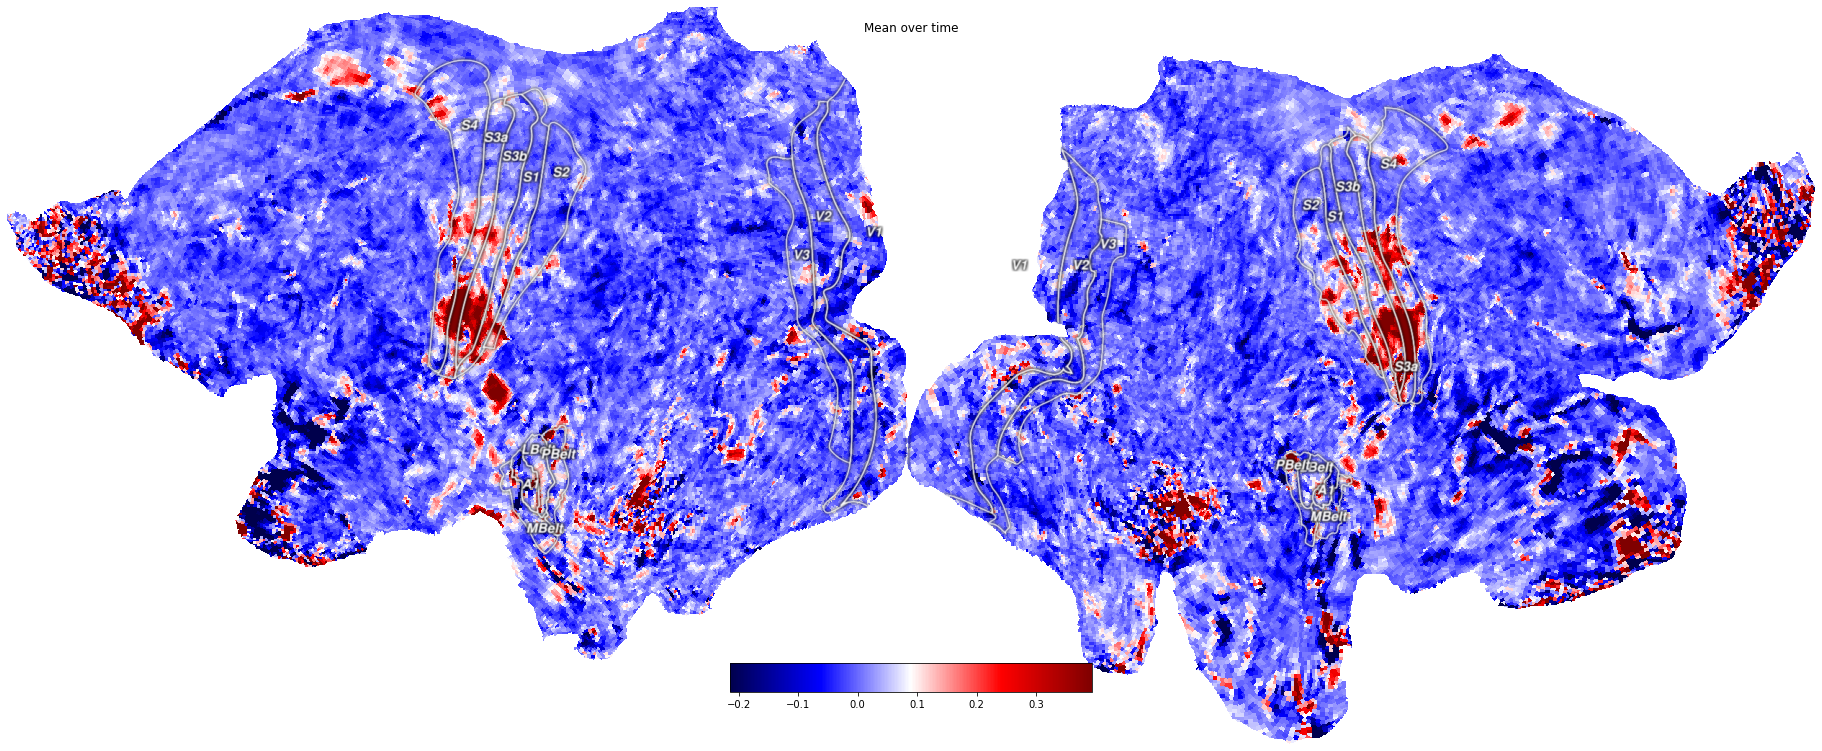

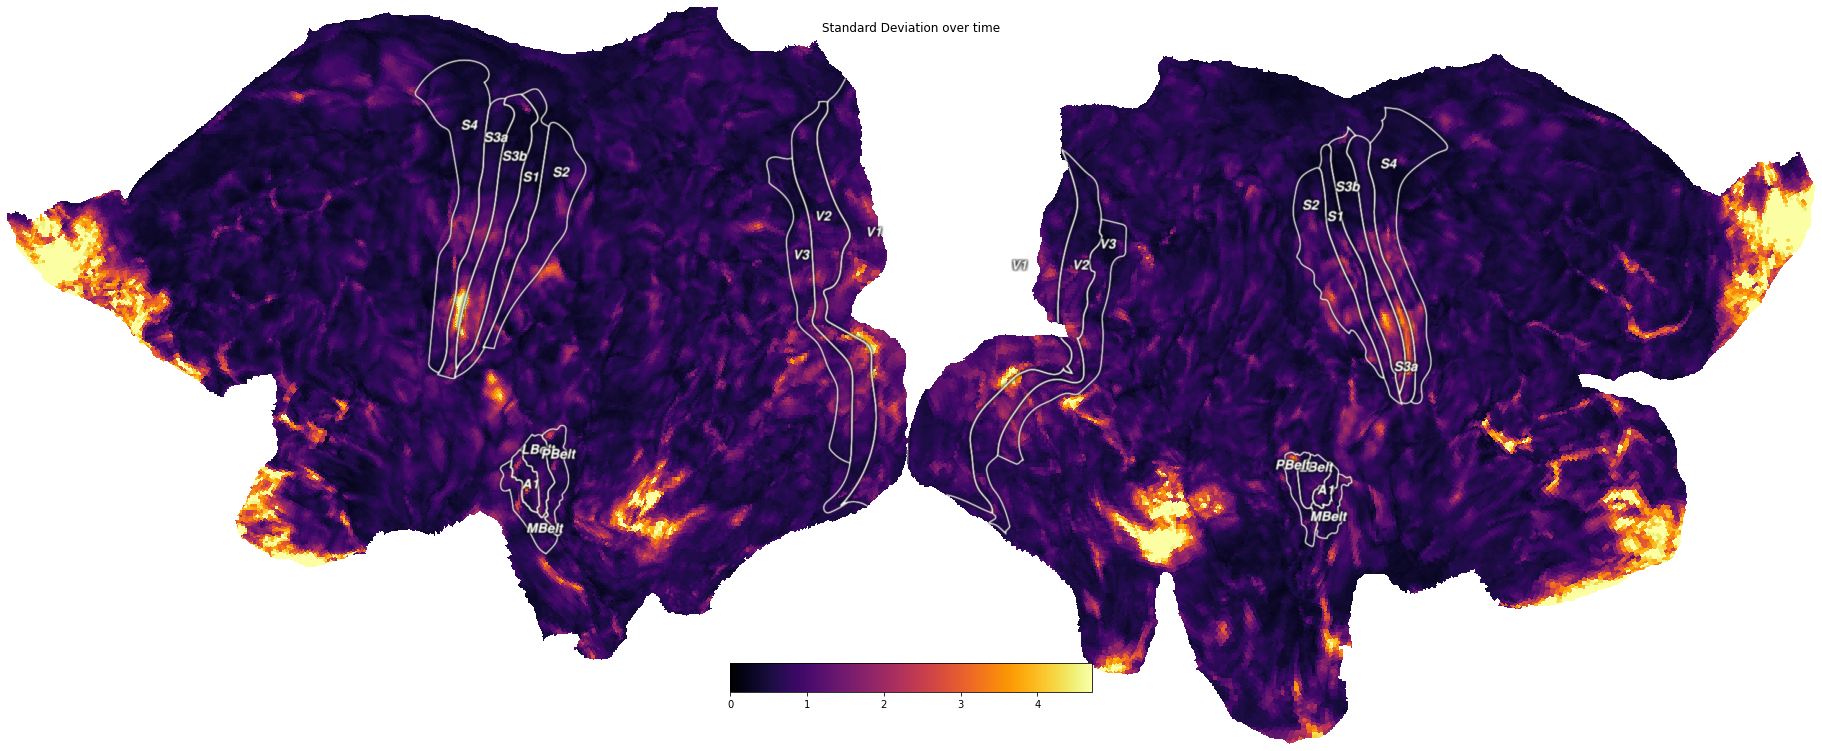

In [6]:
# Note that we saw in the cell above that the second dimension is time, 
# so the axis on which we take the mean and standard deviation is 1
f = cx.quickshow(cx.Vertex(tseries_raw.mean(axis=1), subject='hcp_999999', cmap='seismic'));
f.suptitle('Mean over time')

f = cx.quickshow(cx.Vertex(tseries_raw.std(axis=1), subject='hcp_999999', cmap='inferno'));
f.suptitle('Standard Deviation over time');

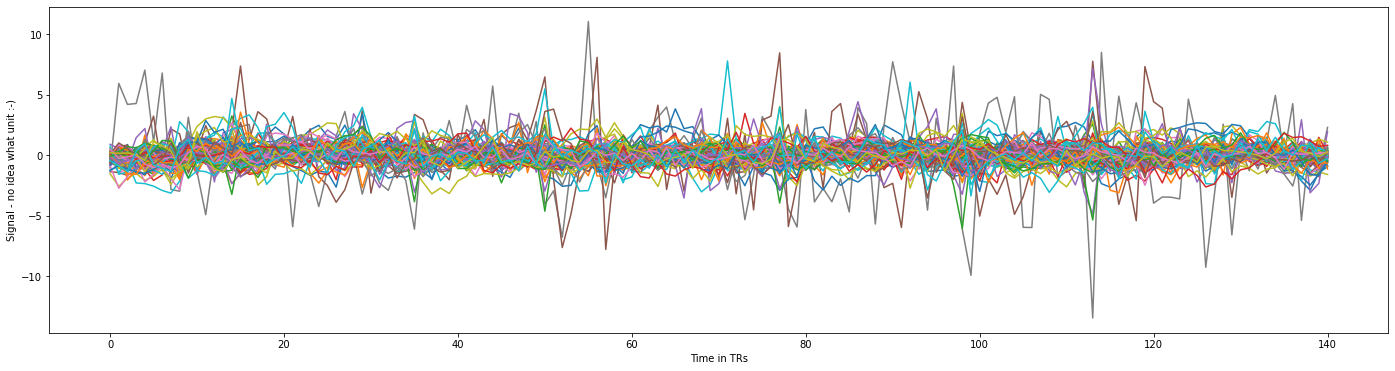

In [7]:
# now, let's get some random time-courses to check whether there's still drift:
random_vertices = np.random.choice(np.arange(tseries_raw.shape[0]), 100)
f = plt.figure(figsize=(24,6))
plt.plot(tseries_raw[random_vertices].T)
plt.xlabel('Time in TRs')
plt.ylabel('Signal - no idea what unit :-)');

In [9]:
# we read in the atlas data, which consists of 180 separate regions per hemisphere. 
# These are labeled separately, so the labels go to 360. 
# To work with them in both hemispheres simultaneously, we mod by 180. 
atlas_data = np.concatenate([load_surf_data(
        os.path.join('/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)

Failed to get connection
** (inkscape:3198): CRITICAL **: 11:43:08.521: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3198): CRITICAL **: 11:43:08.521: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3198): CRITICAL **: 11:43:08.521: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


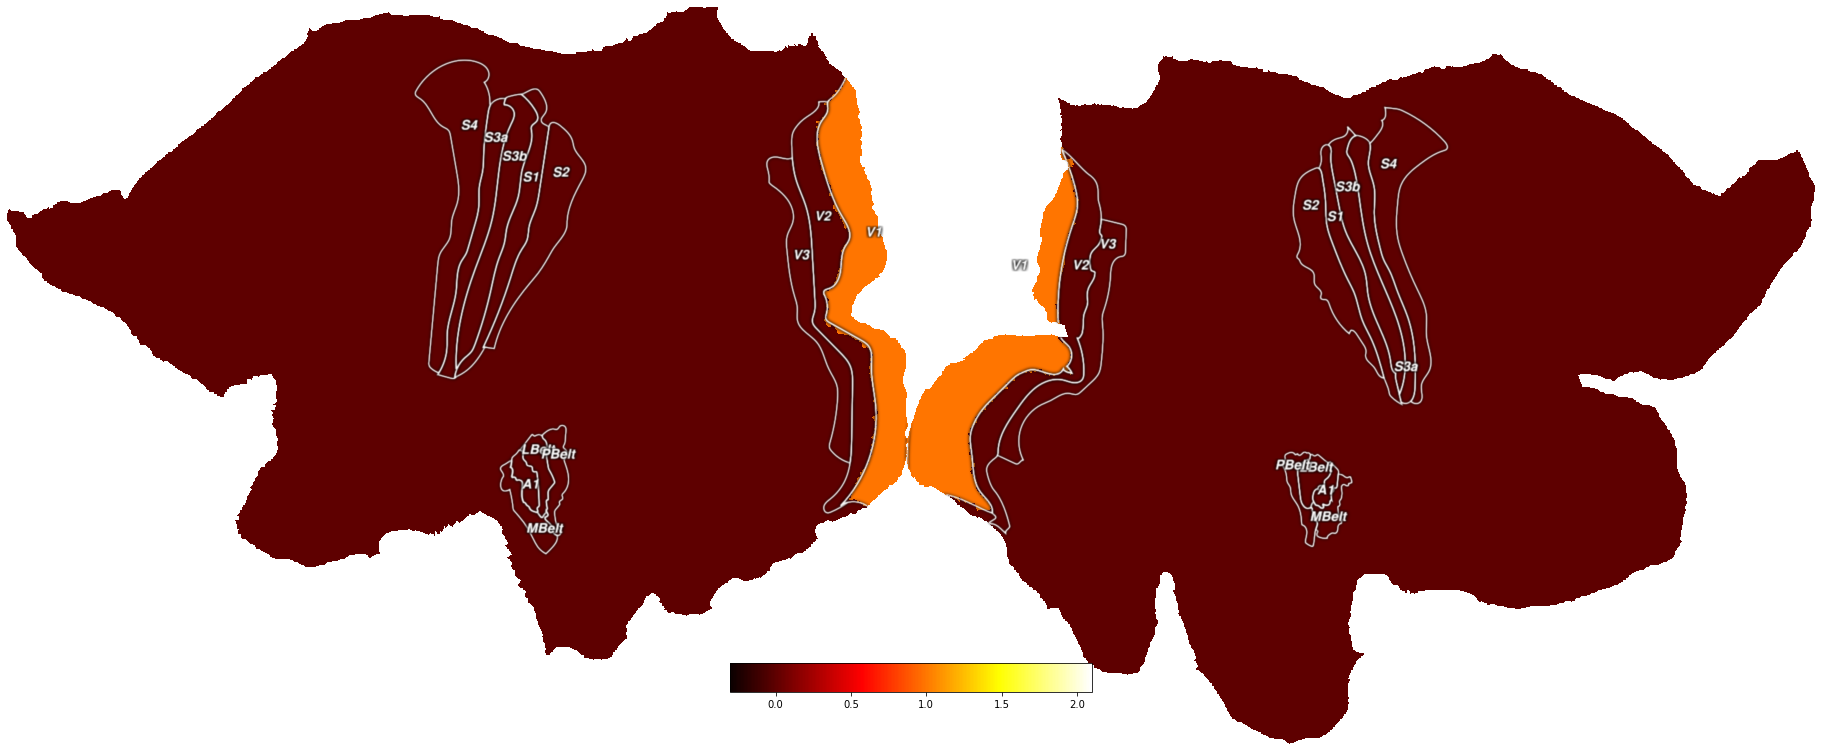

In [10]:
f = cx.quickshow(cx.Vertex(atlas_data_both_hemis == 1, subject='hcp_999999', cmap='hot', vmin=-0.3, vmax=2.1));

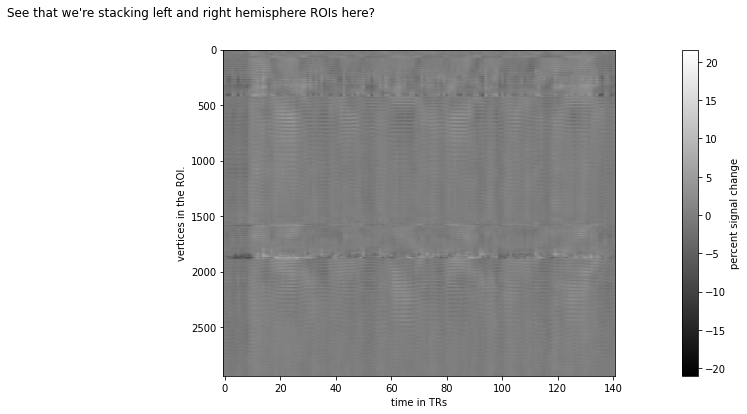

In [11]:
roi_boolean_mask = atlas_data_both_hemis == 1

# but let's look at the actual signals after percent signal change conversion. 
def psc(data):
  """take percent signal change of data along axis 1. 
  This implementation is a bit idiosyncratic since 
  it uses the median instead of the mean of the signal.
  For sparse signals with very strong activations (such as those at 7T)
  this approach makes sense. Can you imagine why?"""
  # crudely checking whether psc hasn't already happened, in which case do nothing
  if np.mean(data) < 0.5:
    return data
  return ((data.T/np.median(data, 1)).T - 1) * 100

f = plt.figure(figsize=(24,6))
plt.imshow(psc(tseries_raw[roi_boolean_mask]), aspect=1/25, cmap='gray')
plt.xlabel('time in TRs')
plt.ylabel('vertices in the ROI.')
plt.colorbar(label='percent signal change')
f.suptitle("See that we're stacking left and right hemisphere ROIs here?");

In [12]:
roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

From these simple surface and time-course plots above, we can immediately gather a couple of things. Try to answer the following questions from both the flatmaps and the random time-courses.

    have these data been z-scored or percent signal changed? Check the colorbars! What would they look like if they'd been z-scored?
    have these data been high-pass filtered? Check the timecourses!
    where do you see the biggest signal fluctuations? What are the likely origins of these fluctuations?

You can use these insights in writing the data description section of your report! Note that there are differences between the different project-datasets, so make sure you inspect your own!

# This is where the actual part of our project starts and where we would implement the GLM

In [29]:
import pandas as pd
expt_df = pd.read_csv('/content/data/soma_mapper_59k/sub-01_ses-01_task-soma_run-median_events.tsv', sep='\t')
a = expt_df['trial_type'].drop_duplicates()
#a.sort()
print(a)

0        eyebrows
1            eyes
2           mouth
3          tongue
4     lhand_fing1
5     lhand_fing2
6     lhand_fing3
7     lhand_fing4
8     lhand_fing5
9            lleg
15    rhand_fing1
17    rhand_fing2
19    rhand_fing3
21    rhand_fing4
23    rhand_fing5
25           rleg
Name: trial_type, dtype: object


In [15]:
# what types of stimuli were shown, and what bodyparts were actually moved?
# unique_event_types = np.unique(expt_df['trial_type'])
# print(unique_event_types)

# let's order these in a sensible way so that when we decide to loop over them, 
# it's easy to keep in mind what we're doing
unique_event_types = ['eyebrows', 'eyes', 'mouth', 'tongue', 'lhand_fing1', 'lhand_fing2', 'lhand_fing3', 'lhand_fing4', 'lhand_fing5', 'lleg',  'rhand_fing1', 'rhand_fing2', 'rhand_fing3',
 'rhand_fing4', 'rhand_fing5', 'rleg']

# so, we can use the pandas DataFrame 
# to easily take the event times for an example event type
# you can use this simple syntax yourself lateron
event_times = np.array(expt_df[expt_df['trial_type'] == 'rhand_fing2']['onset'])

/usr/local/lib/python3.7/dist-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


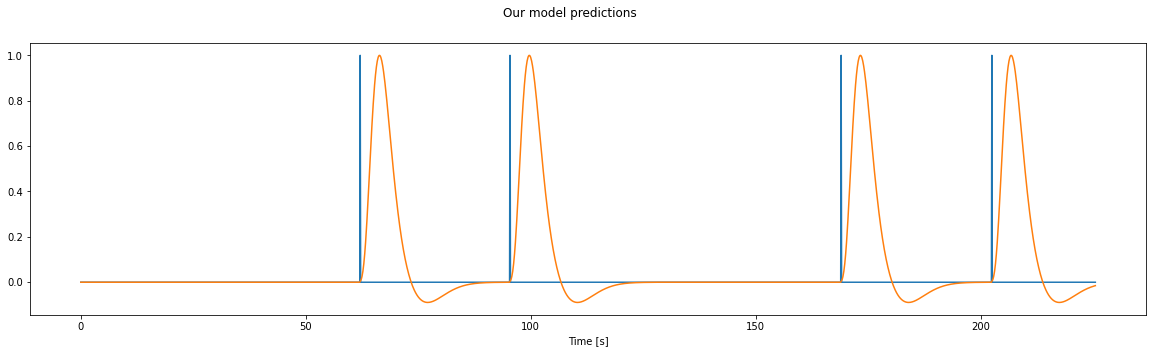

In [16]:
# okay, now that we have event times, we'll be able to create a fine-timing timecourse. 
# I will tell you a secret: the TR in this experiment was 1.6s - you can find this info
# in the figshare website also. 
tr = 1.6

# create 0.1 s timescale regressor, and fill in the events
upscaled_times = np.arange(0, tseries_raw.shape[1]*tr, 0.1)
neural_event_timecourse = np.zeros(int(tseries_raw.shape[1]*tr*10))
# we'll pretend the events were instantaneous, since this will not
# impact the expected response shapes much
neural_event_timecourse[np.round(event_times * 10).astype(int)] = 1 


from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf

hrf = _gamma_difference_hrf(tr=tr ,oversampling=16, onset=-tr/2)
hrf /= hrf.max() # <- normalize HRF

bold_event_timecourse = np.convolve(neural_event_timecourse, hrf, 'full')[:neural_event_timecourse.shape[0]]

f = plt.figure(figsize=(20,5))
plt.plot(upscaled_times, neural_event_timecourse, label='neural')
plt.plot(upscaled_times, bold_event_timecourse, label='BOLD')
plt.suptitle('Our model predictions')
plt.xlabel('Time [s]');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


Failed to get connection
** (inkscape:3285): CRITICAL **: 12:03:51.412: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3285): CRITICAL **: 12:03:51.412: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3285): CRITICAL **: 12:03:51.412: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:3288): CRITICAL **: 12:03:52.742: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3288): CRITICAL **: 12:03:52.742: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3288): CRITICAL **: 12:03:52.742: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


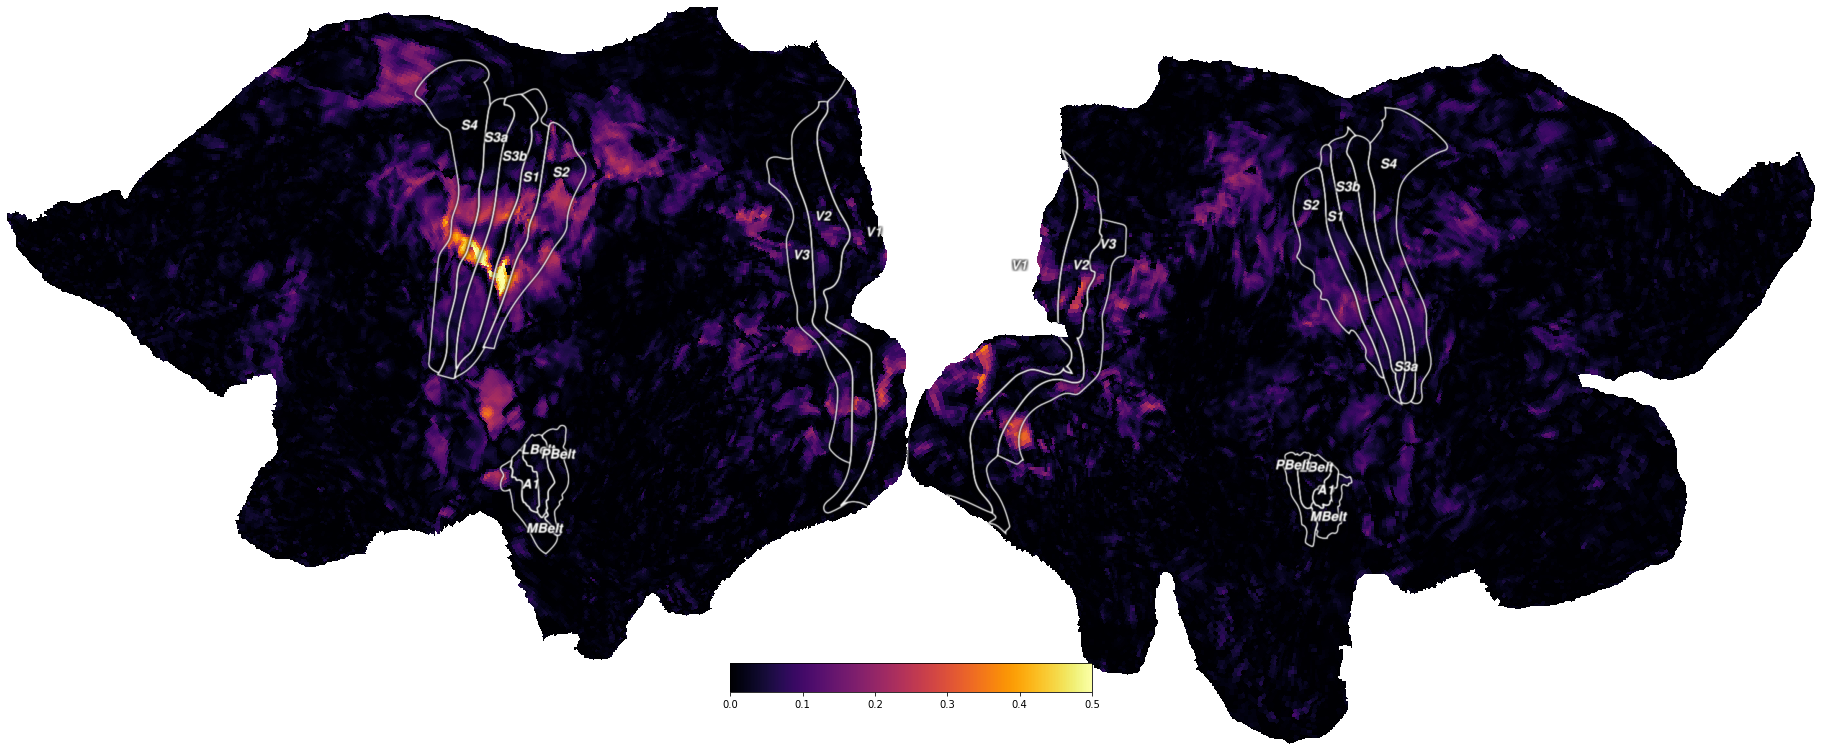

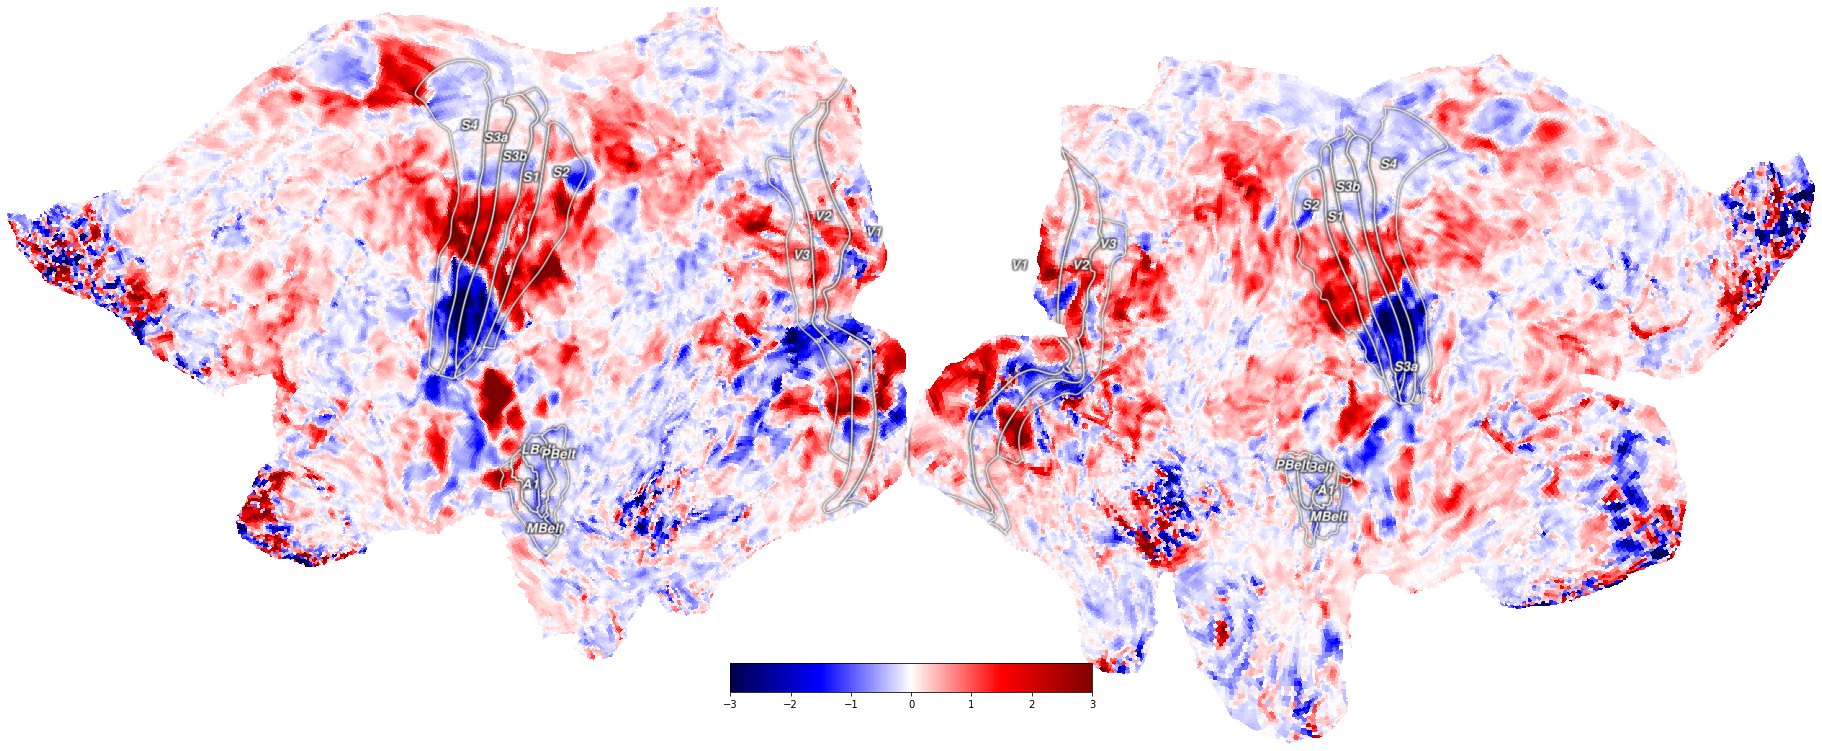

In [17]:
sub_sampled_regressor = bold_event_timecourse[::16]
dm = np.vstack([np.ones_like(sub_sampled_regressor), sub_sampled_regressor]).T

betas, _, _, _ = np.linalg.lstsq(dm, tseries_raw.T)
# let's look at betas[1], since those are our tongue betas 

yhat = np.dot(betas.T, dm.T)
rsq = 1-(yhat-tseries_raw).var(1)/tseries_raw.var(1)

# we can visualize the rsq and beta weights separately
f1 = cx.quickshow(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0, vmax=0.5));

masked_betas = betas[1]
# masked_betas[rsq < 0.3] = np.nan

f2 = cx.quickshow(cx.Vertex(masked_betas, subject='hcp_999999', cmap='seismic', vmin=-3, vmax=3, alpha=rsq));

# or use one to mask the other using a 2D Vertex object, and plotting that. 
# there seems to be a rendering issue, but we'll leave it at this.
# f12 = cx.quickshow(cx.Vertex2D(rsq, betas[1], subject='hcp_999999', cmap='BuWtRd_alpha', vmin=0.1, vmax=1, vmin2=-3, vmax2=3));

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Failed to get connection
** (inkscape:3294): CRITICAL **: 12:04:01.376: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3294): CRITICAL **: 12:04:01.376: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3294): CRITICAL **: 12:04:01.376: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


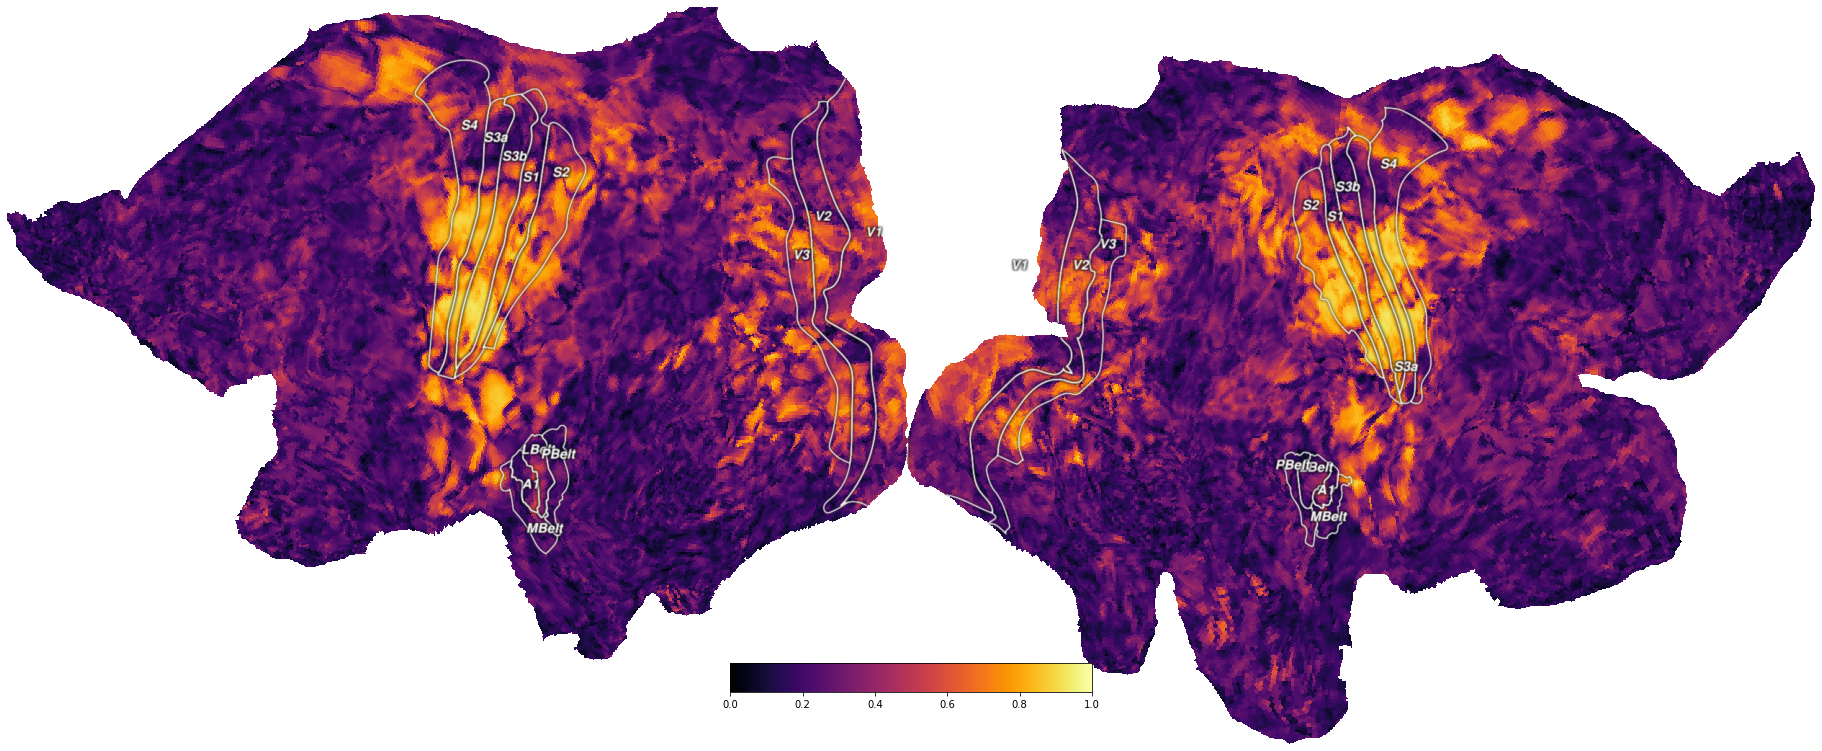

In [18]:
def create_BOLD_regressor(event_times, n_timepoints, tr=1.6, supersampleratio=10):

    # create 0.1 s timescale regressor, and fill in the events
    upscaled_times = np.arange(0, n_timepoints*tr, 1/supersampleratio)
    neural_event_timecourse = np.zeros(int(n_timepoints*tr*supersampleratio))
    # we'll pretend the events were instantaneous, since this will not
    # impact the expected response shapes much. For events with variable durations
    # you'll want to make sure this doesn't happen :-)
    neural_event_timecourse[np.round(event_times * supersampleratio).astype(int)] = 1 

    hrf = _gamma_difference_hrf(tr=tr ,oversampling=tr*supersampleratio, onset=-tr/2)
    hrf /= hrf.max() # <- normalize HRF

    bold_event_timecourse = np.convolve(neural_event_timecourse, hrf, 'full')[:neural_event_timecourse.shape[0]]
    sub_sampled_regressor = bold_event_timecourse[::int(tr*supersampleratio)]
    return sub_sampled_regressor

def create_design_matrix(regressor_types, expt_df, data):
    regressors = [np.ones(data.shape[1])]
    for regressor_type in regressor_types:
        event_times = np.array(expt_df[expt_df['trial_type'] == regressor_type]['onset'])
        regressors.append(create_BOLD_regressor(event_times, data.shape[1]))
    return np.array(regressors)

dm = create_design_matrix(regressor_types=unique_event_types, expt_df=expt_df, data=tseries_raw)

betas, _, _, _ = np.linalg.lstsq(dm.T, tseries_raw.T)
yhat = np.dot(betas.T, dm)

rsq = 1-(yhat-tseries_raw).var(1)/tseries_raw.var(1)

f1 = cx.quickshow(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0, vmax=1));

In [19]:
def gauss1D_cart(x, mu=0.0, sigma=1.0):
    """gauss1D_cart

    gauss1D_cart takes a 1D array x, a mean and standard deviation,
    and produces a gaussian with given parameters, with a peak of height 1.

    Parameters
    ----------
    x : numpy.ndarray (1D)
        space on which to calculate the gauss
    mu : float, optional
        mean/mode of gaussian (the default is 0.0)
    sigma : float, optional
        standard deviation of gaussian (the default is 1.0)

    Returns
    -------
    numpy.ndarray
        gaussian values at x
    """

    return np.exp(-((x-mu)**2)/(2*sigma**2))

# **1.** T-statistic contrast left and right hand

Show the T-statistic of the contrast of "right hand" vs "left hand" to signify contralaterality of the hand representations. This should give you a broad idea of where the hand representation is in our S-named regions of interest (the ones that are green in the HCP flatmap explanation above). Use your knowledge from the glm practical to calculate these statistics, and use a t-statistic threshold of 4 in your visualizations. Do the same for the left foot vs the right foot. 

Failed to get connection
** (inkscape:3304): CRITICAL **: 12:04:32.077: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3304): CRITICAL **: 12:04:32.077: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3304): CRITICAL **: 12:04:32.077: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


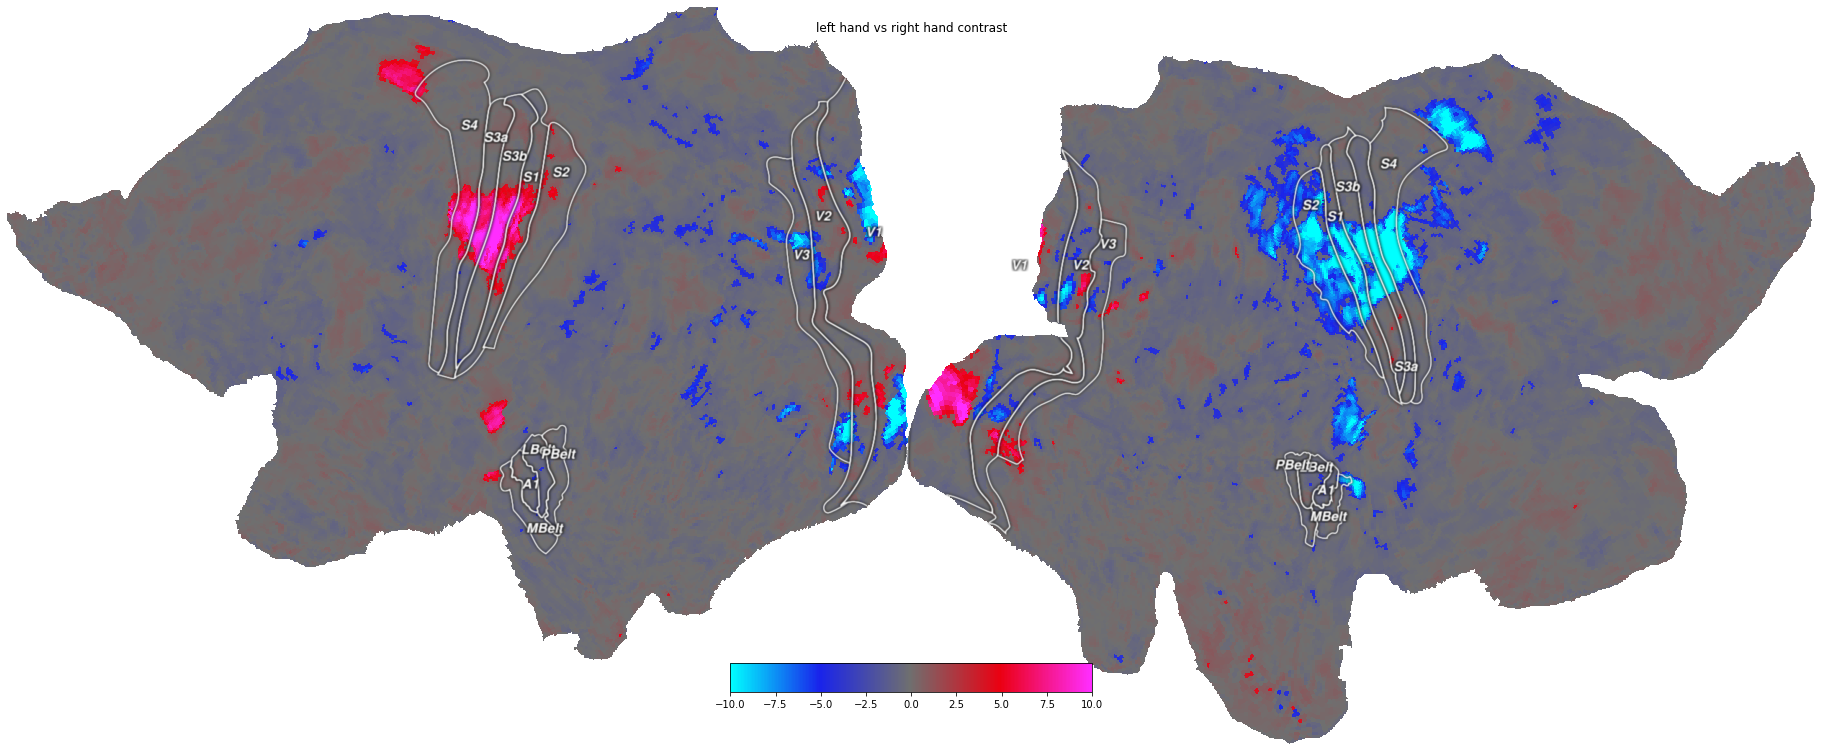

In [20]:
rhands = np.array([1 if 'rhand' in uet else 0 for uet in unique_event_types])
lhands = np.array([-1 if 'lhand' in uet else 0 for uet in unique_event_types])
contrast_vector = np.r_[0, rhands+lhands] # the intercept regressor was never in the event types list

c_betas = np.dot(contrast_vector, betas)

N = tseries_raw.shape[1]
P = betas.shape[0]
df = (N - P)

sigma_hat = np.sum((tseries_raw - yhat) ** 2, axis=1) / df
des_var = contrast_vector.dot(np.linalg.pinv(dm.dot(dm.T))).dot(contrast_vector.T)

t = c_betas / np.sqrt(sigma_hat * des_var)
t[np.abs(t) < 4] = t[np.abs(t) < 4]/4

f2 = cx.quickshow(cx.Vertex(t, subject='hcp_999999', cmap='CyanBlueGrayRedPink', vmin=-10, vmax=10));
f2.suptitle('left hand vs right hand contrast');

This code was already written in the backbone_project. The image above shows the contrast of'right hand'and 'left hand'.

Failed to get connection
** (inkscape:3380): CRITICAL **: 12:14:24.644: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3380): CRITICAL **: 12:14:24.644: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3380): CRITICAL **: 12:14:24.644: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


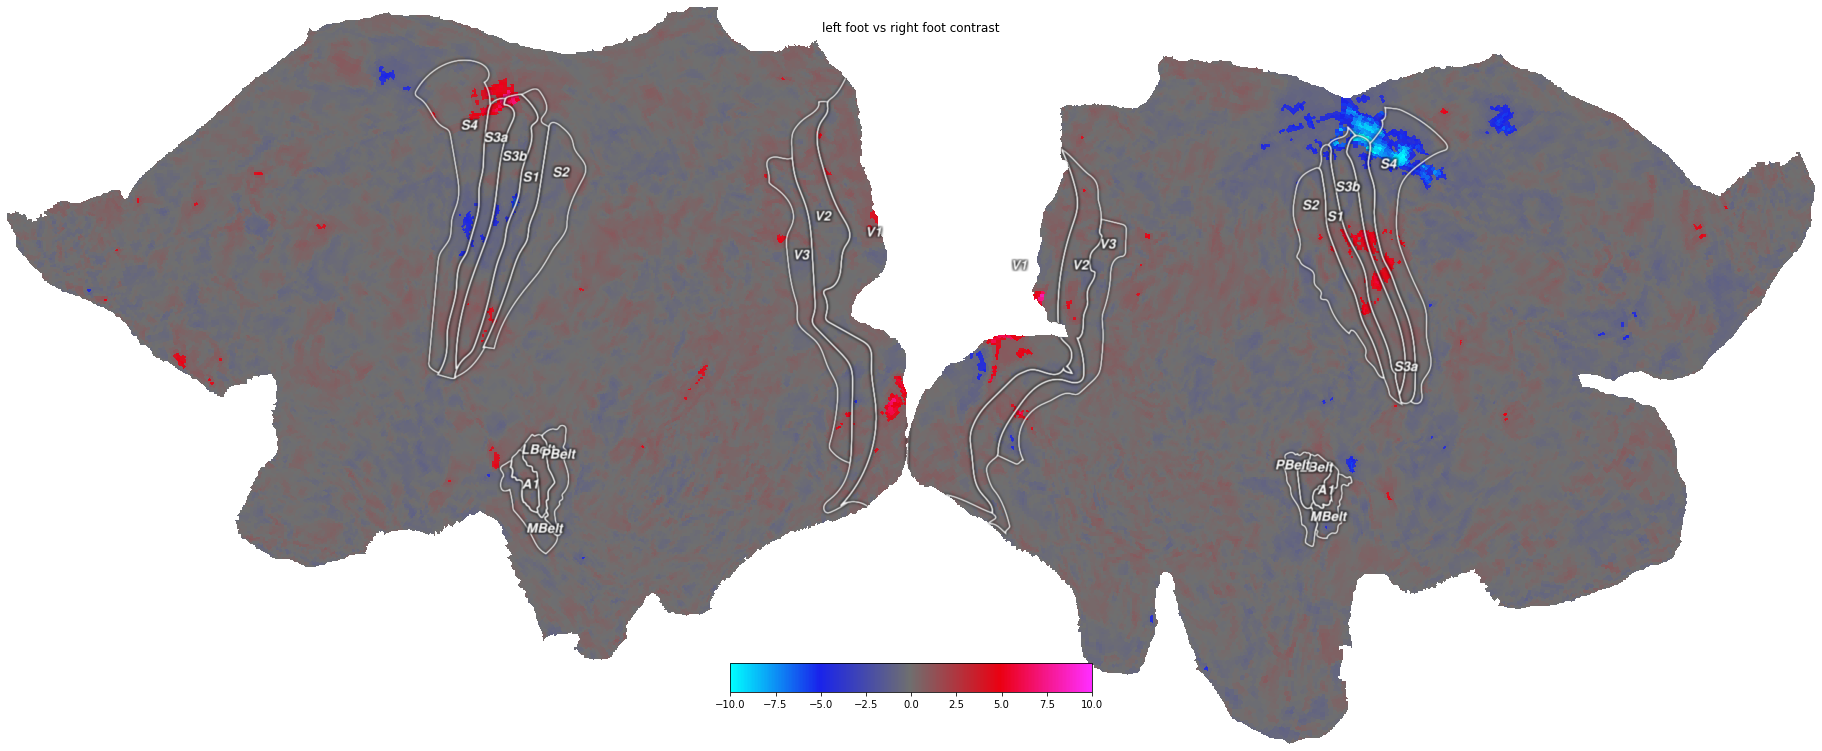

In [30]:
rfoot = np.array([1 if 'rleg' in uet else 0 for uet in unique_event_types])
lfoot = np.array([-1 if 'lleg' in uet else 0 for uet in unique_event_types])
contrast_vector = np.r_[0, rfoot+lfoot] # the intercept regressor was never in the event types list

c_betas = np.dot(contrast_vector, betas)

N = tseries_raw.shape[1]
P = betas.shape[0]
df = (N - P)

sigma_hat = np.sum((tseries_raw - yhat) ** 2, axis=1) / df
des_var = contrast_vector.dot(np.linalg.pinv(dm.dot(dm.T))).dot(contrast_vector.T)

t = c_betas / np.sqrt(sigma_hat * des_var)
t[np.abs(t) < 4] = t[np.abs(t) < 4]/4

f2 = cx.quickshow(cx.Vertex(t, subject='hcp_999999', cmap='CyanBlueGrayRedPink', vmin=-10, vmax=10));
f2.suptitle('left foot vs right foot contrast');

The above image shows the conrast between the left foot and right foot. Unfortunately the dataset calls it left leg or right leg. I am assuming that that is what they mean by foot (otherwise the dataset is missing some crucial information).